In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import mediapy

from toy2d import (
    MLP,
    MultiResVoxel,
    MultiResVoxelMLP,
    InterpMultiResVoxel,
    optim_input,
    visualize_field,
    optim_model,
    MLP,
)


In [ ]:
import imageio
import cv2
import matplotlib.pyplot as plt
from tava.models.basic.posi_enc import PositionalEncoder

texture_img = imageio.imread("pug.jpg")
texture_img = cv2.resize(texture_img, (500, 500))

rgb_cano = torch.from_numpy(texture_img).float() / 255.0
x_cano = torch.stack(
    torch.meshgrid(
        torch.linspace(0, 1, texture_img.shape[1]),
        torch.linspace(0, 1, texture_img.shape[0]),
        indexing="ij"
    ),
    dim=-1
)
posi_encoder = PositionalEncoder(2, 0, 10)

print ("x_cano", x_cano.shape, "rgb_cano", rgb_cano.shape)


plt.imshow(texture_img)
plt.axis("off")
plt.show()

In [ ]:
import torch.nn as nn
model = nn.Sequential(
    MLP(
        input_dim=posi_encoder.out_dim, 
        net_depth=8, 
        net_width=64, 
        skip_layer=4, 
        output_dim=3,
        input_activation=lambda x: posi_encoder(x),  # to [0, 1]
    ),
    torch.nn.Sigmoid(),
)
rgb_pred = optim_model(model, x_cano, rgb_cano, lr=1e-2, max_steps=1000, device="cuda:0", optim=torch.optim.Adam)

import matplotlib.pyplot as plt
plt.imshow(rgb_pred.detach().cpu().numpy())
plt.show()

In [ ]:
x = torch.rand((10, 2))
x_gt = torch.rand((10, 2))
x_opt, error, images = optim_input(
    model, x, x_gt, lr=1e-4, max_steps=200, canvas=texture_img, 
    input_act=lambda x: x, 
    device="cuda:1",
    optim=torch.optim.Adam,
)
mediapy.show_video(images, height=250, codec='gif', fps=4)


In [ ]:
import torch
import mediapy

from toy2d import (
    MLP,
    MultiResVoxel,
    MultiResVoxelMLP,
    InterpMultiResVoxel,
    optim_input,
    visualize_field,
    optim_model,
)

#### MLP

step 0000049 lr 100000.0000: loss 0.0000000 grad 0.0000000 err  0.0000000 : 100%|██████████| 50/50 [00:07<00:00,  6.29it/s]


""

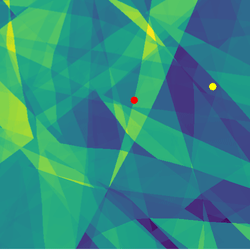

In [9]:
x = torch.randn((1, 2))
x_gt = torch.randn((1, 2))
model = MLP(
    input_dim=2, 
    net_depth=8, 
    net_width=64, 
    skip_layer=4, 
    output_dim=20,
)
x_opt, error, images = optim_input(model, x, x_gt, lr=1e5, max_steps=50)
mediapy.show_video(images, height=250, codec='gif', fps=4)

input = torch.stack(
    torch.meshgrid(
        torch.linspace(0, 1, 500),
        torch.linspace(0, 1, 500),
        indexing="ij"
    ),
    dim=-1
)
target = model(input, enable_act=False)

#### Bilinear Voxel

step 0000049 lr 10.0000: loss 0.0013845 grad 0.0000000 err  0.0019961 : 100%|██████████| 50/50 [00:07<00:00,  6.66it/s]


""

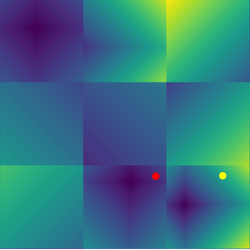

In [18]:
x = torch.randn((1, 2))
x_gt = torch.randn((1, 2))
model = MultiResVoxel(
    res=[4], 
    input_dim=2, 
    interp_mode="bilinear", # "bilinear" | "bicubic"
    output_dim=[20],
)
# _ = optim_model(
#     model, input, target.detach(), 1e2, 200, 
#     device="cuda:1", verbose=True, optim = torch.optim.SGD
# )
x_opt, error, images = optim_input(model, x, x_gt, lr=1e1, max_steps=50)
mediapy.show_video(images, height=250, codec='gif', fps=4)


#### Bicubic Voxel

step 0000019 lr 10.0000: loss 0.0000000 grad 0.0000000 err  0.0000000 : 100%|██████████| 20/20 [00:03<00:00,  5.90it/s]


""

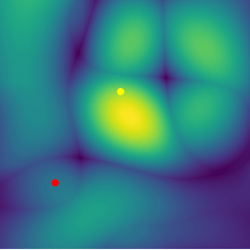

In [26]:
x = torch.randn((1, 2))
x_gt = torch.randn((1, 2))
model = MultiResVoxel(
    res=[4], 
    input_dim=2, 
    interp_mode="bicubic", # "bilinear" | "bicubic"
    output_dim=[20],
)
# _ = optim_model(
#     model, input, target.detach(), 1e1, 5000, 
#     device="cuda:1", verbose=True, optim = torch.optim.SGD
# )
x_opt, error, images = optim_input(model, x, x_gt, lr=1e1, max_steps=20)
mediapy.show_video(images, height=250, codec='gif', fps=4)


#### Bicubic Multi-Res Voxel

In [ ]:
x = torch.randn((10, 2))
x_gt = torch.randn((10, 2))
model = MultiResVoxel(
    res=[2,3,4], 
    input_dim=2, 
    interp_mode="bicubic", # "bilinear" | "bicubic"
    output_dim=[60,40,20],
)
x_opt, error, images = optim_input(model, x, x_gt, lr=1e2, max_steps=50)
mediapy.show_video(images, height=250, codec='gif', fps=4)


In [ ]:
x = torch.randn((10, 2))
x_gt = torch.randn((10, 2))
model = MultiResVoxel(
    res=[2,4,8], 
    input_dim=2, 
    interp_mode="bicubic", # "bilinear" | "bicubic"
    output_dim=[60,40,20],
)
x_opt, error, images = optim_input(model, x, x_gt, lr=1e1, max_steps=100)
mediapy.show_video(images, height=250, codec='gif', fps=4)


#### Interpolated Multi-res Voxel

In [ ]:
x = torch.randn((10, 2))
x_gt = torch.randn((10, 2))
model = InterpMultiResVoxel(
    multi_res=[2,3,4], 
    input_dim=2, 
    interp_mode="bicubic", # "bilinear" | "bicubic"
    output_dim=50,
)
x_opt, error, images = optim_input(model, x, x_gt, lr=1e2, max_steps=50)
mediapy.show_video(images, height=250, codec='gif', fps=4)


In [ ]:
x = torch.randn((10, 2))
x_gt = torch.randn((10, 2))
model = InterpMultiResVoxel(
    multi_res=[2,4,8], 
    input_dim=2, 
    interp_mode="bicubic", # "bilinear" | "bicubic"
    output_dim=50,
)
x_opt, error, images = optim_input(model, x, x_gt, lr=1e1, max_steps=50)
mediapy.show_video(images, height=250, codec='gif', fps=4)


### On Real Image 2D

In [ ]:
import imageio
import cv2
import matplotlib.pyplot as plt

texture_img = imageio.imread("pug.jpg")
texture_img = cv2.resize(texture_img, (500, 500))

plt.imshow(texture_img)
plt.axis("off")
plt.show()

In [ ]:
import numpy as np

# bicubic voxel

model = MultiResVoxel(
    res=[2, 4, 8, 16, 32], 
    input_dim=2, 
    interp_mode="bicubic", # "bilinear" | "bicubic"
    output_dim=[32, 8, 16, 4, 2],
)
for voxel in model.voxels:
    voxel.data.data = torch.tensor(
        cv2.resize(texture_img, (voxel.res, voxel.res))
    ).float().permute(2, 0, 1).unsqueeze(0)

coords = torch.stack(
    torch.meshgrid(
        torch.linspace(0, 1, texture_img.shape[1]),
        torch.linspace(0, 1, texture_img.shape[0]),
        indexing="ij"
    ),
    dim=-1
)
rgb = model(coords, enable_act=False)
print (rgb.min(), rgb.max(), rgb.shape)
# rgb = rgb.clamp(0, 255)

# plt.imshow(rgb.detach().cpu().numpy().astype(np.uint8))
# plt.axis("off")
# plt.show()

In [ ]:
x_opt, error, images = optim_input(model, x, x_gt, lr=1e-4, max_steps=200)
mediapy.show_video(images, height=250, codec='gif', fps=4)

In [ ]:
x = torch.randn((1, 2))
x_gt = torch.randn((1, 2))
model = MultiResVoxel(
    res=[2,3,4,5,6], 
    input_dim=2, 
    output_dim=[32,16,8,8,8], 
    interp_mode="bicubic", # "bilinear" | "bicubic"
)
x_opt, error, images = optim_input(model, x, x_gt, lr=1e1, max_steps=30)
mediapy.show_video(images, height=250, codec='gif', fps=4)


In [ ]:
x = torch.randn((1, 2))
x_gt = torch.randn((1, 2))
model = MLP(
    input_dim=2, 
    net_depth=8, 
    net_width=128, 
    skip_layer=4, 
    output_dim=1,
)

x_opt, error, images = optim_input(model, x, x_gt, lr=1e5, max_steps=50)
mediapy.show_video(images, height=250, codec='gif', fps=4)
